In [3]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

/home/ubuntu/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/crops'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

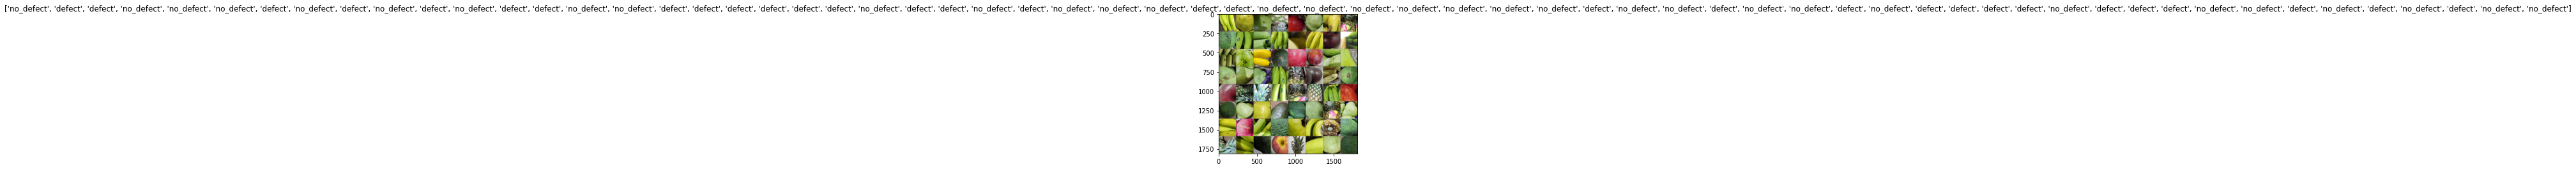

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():dataloaders
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7969 Acc: 0.4130
val Loss: 0.8081 Acc: 0.4333

Epoch 1/24
----------
train Loss: 0.6805 Acc: 0.5668
val Loss: 0.6482 Acc: 0.6500

Epoch 2/24
----------
train Loss: 0.5383 Acc: 0.7490
val Loss: 0.5129 Acc: 0.7667

Epoch 3/24
----------
train Loss: 0.4786 Acc: 0.7895
val Loss: 0.4374 Acc: 0.8000

Epoch 4/24
----------
train Loss: 0.4177 Acc: 0.8219
val Loss: 0.3895 Acc: 0.8000

Epoch 5/24
----------
train Loss: 0.4017 Acc: 0.8097
val Loss: 0.3606 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.3693 Acc: 0.8219
val Loss: 0.3313 Acc: 0.8167

Epoch 7/24
----------
train Loss: 0.3523 Acc: 0.8462
val Loss: 0.3325 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.3409 Acc: 0.8381
val Loss: 0.3355 Acc: 0.8000

Epoch 9/24
----------
train Loss: 0.3149 Acc: 0.8381
val Loss: 0.3340 Acc: 0.7833

Epoch 10/24
----------
train Loss: 0.3210 Acc: 0.8462
val Loss: 0.3319 Acc: 0.7833

Epoch 11/24
----------
train Loss: 0.3333 Acc: 0.8502
val Loss: 0.3298 Acc: 0.8000

Ep

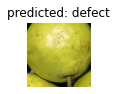

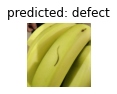

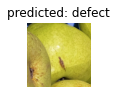

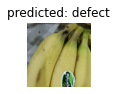

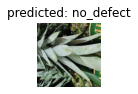

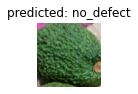

In [10]:
visualize_model(model_ft)

In [14]:
dir = "../results/defect_detection"
PATH = os.path.join(dir, "20220826_ep25.pt")
if not os.path.exists(dir):
    os.makedirs(dir)
torch.save(model_ft.state_dict(), PATH)

In [17]:
model_ld = TheModelClass(*args, **kwargs)
model_ld.load_state_dict(torch.load(PATH))
model_ld.eval()

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

In [28]:
idx_to_class = {0: "defect", 1: "no_defect"}

def predict(model, test_image_name):
    transform = data_transforms['val']
    test_image = Image.open(test_image_name).convert('RGB')
    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        print("Output class :  ", idx_to_class[topclass.cpu().numpy()[0][0]])

Output class :   defect


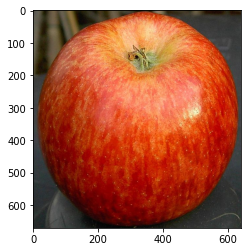

In [53]:
test_image_dir = "../data/crops/test/"
test_image_name = os.path.join(test_image_dir, "no2.jpeg")
predict(model_ft, test_image_name)

Output class :   defect
Output class :   no_defect
Output class :   defect
Output class :   defect
Output class :   no_defect
Output class :   defect
Output class :   no_defect
Output class :   defect
Output class :   defect
Output class :   no_defect
Output class :   defect
Output class :   defect
Output class :   defect


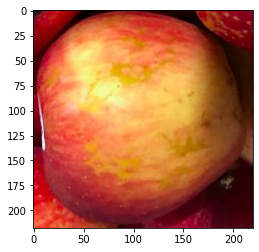

In [34]:
test_image_dir = "../data/crops/test/"
for i in os.listdir(test_image_dir):
    test_image_name = os.path.join(test_image_dir, i)
    try:
        predict(model_ft, test_image_name)
    except:
        continue